<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/Vyimov-Zorislav-folder/Zorislav_Vyymov/Zorislav_Vyymov_Internship_counters_3_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics                     # Эта команда используется для установки пакета ultralytics с использованием инструмента
                                             # pip. ultralytics - это библиотека, которая предоставляет удобные средства для работы с
                                             # задачами обнаружения объектов, классификации и сегментации. Установка этого пакета позволяет
                                             # использовать его функции и классы в коде ниже.
from IPython.display import clear_output     # Эта строка импортирует функцию clear_output из модуля IPython.display. clear_output используется
                                             # для очистки вывода Jupyter Notebook (или GoogleColaboratory) в текущей ячейке, что может быть
                                             # полезно, например, для удаления предыдущих результатов или вывода ошибок перед запуском новой команды.
clear_output()                               # Запуск функции clear_output

In [ ]:
import cv2, os                    # Эти строки кода импортируют модули cv2 (OpenCV) и os.
                                  # cv2 - это библиотека для обработки изображений и компьютерного зрения, которая предоставляет множество
                                  # функций для работы с изображениями, включая загрузку, обработку, анализ и многое другое.
                                  # os - это модуль для работы с операционной системой, и он позволяет выполнять различные операции с файлами
                                  # и директориями, такие как создание, удаление и манипуляции с путями к файлам и папкам.
import numpy as np                # Эта строка кода импортирует библиотеку NumPy и задает ей псевдоним np. NumPy - это библиотека для работы
                                  # с массивами и матрицами, и она часто используется для выполнения численных операций и анализа данных.
from ultralytics import YOLO      # импортирует класс YOLO из модуля ultralytics. ultralytics - это библиотека, которая предоставляет удобные
                                  # средства для работы с моделями YOLO (You Only Look Once) для задач обнаружения объектов. Класс YOLO
                                  # предоставляет интерфейс для работы с моделями YOLO и облегчает выполнение задачи обнаружения объектов на
                                  # изображениях (и видео).

In [ ]:
# подключение диска:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Создание обученной НС, определяющей на изображениии счетчика (фото) несколько характерных объектов, каждому их которых мы присвоим свой класс:
 - цифра основного показателя  измерения (целой его части). Это будут классы от 0 до 9, т.е. каждой цифре присвоим соответсвующий класс;
 - область дробной части основного показателя, если она присутствует на изображении. Этот класс будет иметь название "дополнительное";
 - область размещения на фото серийного номера прибора учета. В дальнейшем мы подадим его на распознавание другой нейронке, назначением которой будет определить этот номер. Класс назовем "номер";
 - область размещения основного показателя измерения (целой его части) на фото прибора учета. Название этого класса "основное". Именно на этой области фото прибора размещаются классы, соответствующие цифрам показателя измерения;
 - область размещения на фото прибора признака тарифного плана, к которому относится основной показатель. Это характерно для мультитарифных электросчетчиков, замеряющих раздельно расход например в дневное и ночное время. Этот класс с названием "режим" присутствует не на каждом фото. Но если он есть, важно его определеить, распознать и соотнести с распознанным основным показателем и серийным номером прибора. Все три распознанных значения должны составить одну запись в БД с временным штампом события съемки прибора учета.


Для обучения НС необходим размеченный датасет, т.е. набор фото приборов учета, собранных заказчиком, должен обогатиться разметкой вышеуказанных классов объектов на нем. Разметка производилась членами команды с использованием инструмента CVAT. При этом на снимках прямоугольными полигонами,  ориентированными в пространстве соответственно изображению, выделялся каждый из заданных классов, при условии его наличия на снимке. Обязательная пара "основное" и "номер" присутствует на каждом снимке. Классы цифр основного показателя (целая часть) так же присутствуют на каждом снимке, при условии читаемости его содержимого. Нечитаемые области просто не размечаются, а снимки без обязательных разметок отбраковываются - удаляются из обучающего датасета.
Выполненная разметка выгружается из CVAT в виде сегментированных масок.
Для того чтобы выгруженная маска класса "основное" не покрывала на изображениях маски классов цифр основного показателя, перед выгрузкой разметки класса "основное" перемещены в CVAT на нижний слой (background).

В результате этой подготовительной работы в дополнение к изображениям (фото) приборов учета получены сегментированные маски классов на них.

Теперь выполняем следующую задачу:

 для каждой маски сегментации (а это - отдельный файл в папке SegmentationClass) создается аннотация в формате YOLO (тоже файл), где каждый объект (класс) представлен своим идентификатором и координатами полигона, описывающего его форму на изображении.

 Эти аннотации будут затем использоваться для обучения модели сегментации, поддерживающей формат YOLO.

Содержимое файла labelmap в каждом файле архива, выгруженного из CVAT после разметки полигонов каждого из классов объектов на изображениях, предоставляет собой маппинг между идентификаторами классов (номерами/названиями) и цветами в формате RGB. Это можно использовать для преобразования масок сегментации в аннотации  формата YOLO.



 Каждая строка в файле labelmap имеет следующий формат:

 **class_id:color_rgb:parts:actions**

Два последних элемента не используются в задаче. Два первых являются предметом обработки с использованием кода Python в ячейках ниже.


Код ниже предполагает наличие такой структуры директории и файлов:

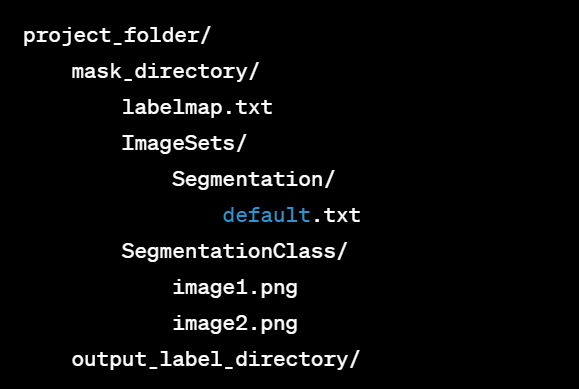

In [ ]:
# @title /mask_to_yolo_annotations/ Определение функции преобразования масок сегментации в анотацию формата YOLO
def mask_to_yolo_annotations(mask_dir, label_dir):              # определение функции
    ''' Из масок сегментации формирует аннотации в формате YOLO.
    На вход функции подается:
    mask_dir - путь к директории с масками сегментации в папке SegmentationClass и папке ImageSets в которой есть папка Segmentation в которой default.txt;
            в этой же директории должна быть папка JPEGImages c изображениями в названиях = названиям
    label_dir - путь к директории, в которой будут сохранены аннотации в формате YOLO.'''

    if not os.path.isdir(mask_dir):                             # Эта строка проверяет, существует ли директория mask_dir. Если она не существует,
        print ('Директории, указанной в первом аргументе, не существует. Укажите правильный путь к директории с масками сегментации')
        return                                                  # функция завершает выполнение и возвращает None

    if not os.path.isdir(label_dir):                            # Эта строка проверяет, существует ли директория label_dir. Если она не существует,
        os.makedirs(label_dir)                                  # то создается новая директория с этим именем с помощью os.makedirs(label_dir).

    labelmap_path = os.path.join(mask_dir, 'labelmap.txt')      # Эта строка формирует путь к файлу labelmap.txt в директории mask_dir
                                                                # с помощью функции os.path.join.
    color_dict = {}                                             # Эта строка создает пустой словарь color_dict, который будет использоваться для
                                                                # хранения соответствия идентификаторов классов и цветов.
    with open(labelmap_path, 'r') as f:                         # открывает файл labelmap.txt для чтения и
        for line in f:                                          # начинаем его обработку построчно:
            if line and line[0] != '#':                         # если строка не пустая и ее первый элемент не сивол "#" (символ комментария)
                parts = line.strip().split(':')                 # делим на части, разделенные символом ":"
                class_id = parts[0]                             # присвоить то, что до первого разделителя переменной class_id
                color_rgb = parts[1]                            # присвоить то, что после первого разделителя ":" переменной color_rgb
                if class_id != 'background':                    # проверяем, что идентификатор класса не равен 'background', иначе класс игнорируется.
                    color_bgr = tuple(map(int, color_rgb.split(',')))[::-1]     # Эта строка преобразует RGB-представление цвета в кортеж целых чисел,
                    color_dict[class_id] = color_bgr                            #  меняя порядок компонент цвета на BGR. Этот кортеж используется для
                                                                                # определения цветов классов. См. пояснение в текстовой ячейке ниже
    image_set_path = os.path.join(mask_dir, 'ImageSets/Segmentation/default.txt') # Эта строка формирует путь к файлу default.txt в директории
                                                                                  # ImageSets/Segmentation внутри mask_dir.
    with open(image_set_path, 'r') as f:                              # Этой строкой кода открываем файл по сформированному пути и читаем его
        image_names = [line.strip() for line in f if line.strip()]    # Эта строка формирует список имен изображений, удаляя начальные и конечные
                                                                      # пробелы и пустые строки. См. пояснения в текстовой строке ниже.
    for image_name in image_names:                                    # Этот цикл перебирает имена изображений из списка.
        mask_path = os.path.join(mask_dir, 'SegmentationClass', image_name + '.png')  # Эта строка формирует путь к файлу с маской сегментации для изображения.
        label_path = os.path.join(label_dir, image_name + '.txt')     # Эта строка формирует путь к файлу, в который будут записаны аннотации в формате YOLO.

        mask = cv2.imread(mask_path)            # Эта строка загружает маску сегментации в переменную mask с использованием библиотеки OpenCV

        img_height, img_width, _ = mask.shape   # Эта строка получает высоту и ширину изображения. Переменная "_" примет глубину (третий элемент в результате
                                                # применения метода .shape. Но он нам не нужен, забываем про него)
        annotations = []                        # Создаем пустой список для анотаций

        for class_id, color_bgr in color_dict.items(): # Этот блок кода перебирает вышесозданный словарь color_dict, где соответствие идентификаторов классов и цветов.
            binary_mask = cv2.inRange(mask, color_bgr, color_bgr)  # Эта строка создает бинарную маску. См доп инфу в текстовой ячейке ниже.
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Эта строка находит контуры объектов на бинарной маске.
                                                        # Используются функции Open CV. См доп. инфу в текстовой ячейке ниже.
            for contour in contours:                    # Для каждого найденного контура:
                x, y, w, h = cv2.boundingRect(contour)  # Записываем координаты крайней левой верхней точки контура, ширину и высоту объекта в 4 переменных
                x_center = (x + w / 2) / img_width      # Пояснение по строке выше см в текстовой ячейке ниже
                y_center = (y + h / 2) / img_height     # Далее находим центр объекта и переводим полученные величины в относительные от ширины и высоты картинки
                width = w / img_width
                height = h / img_height

                annotation = f"{class_id} {x_center} {y_center} {width} {height}" # В переменную annotation записываем полученные величины и добавляем переменную
                annotations.append(annotation)                                    # в вышесозданный список annotations. Этим действием цикл формирования списка по
                                                                                  # данным файлов labelmap.txt и default.txt  завершается. Список заполнен
        with open(label_path, 'w') as f:                                          # Запись списка annotations в виде файла в директорию label_path, в котром
            f.write('\n'.join(annotations))                                       # каждый элемент списка записан с разделителем \n.  См. доп инфу в ячейке ниже

Некоторые дополнительные пояснения к коду функции выше.

**Строки 27-28:**

Этот элемент кода выполняет следующие действия:

color_rgb.split(','): Это разделяет строку color_rgb, которая представляет собой RGB-представление цвета, используя запятые в качестве разделителя. Результатом будет список строк, представляющих значения красного, зеленого и синего каналов цвета.

map(int, ... ): Это преобразует каждую строку в списке (каждый канал цвета) в целое число с помощью функции int. Теперь у нас есть список целых чисел, представляющих значения каналов цвета.

tuple(...): Это создает кортеж из списка целых чисел. Кортеж является неизменяемым объектом, который будет использоваться для представления цвета.

[::-1]: Это переворачивает порядок элементов в кортеже. В исходной строке color_rgb представление цвета было в формате RGB (красный, зеленый, синий), но формат BGR (синий, зеленый, красный) более распространен в компьютерном зрении и в некоторых библиотеках, включая OpenCV. Поэтому [::-1] меняет порядок каналов, чтобы представить цвет в формате BGR.

color_dict[class_id] = color_bgr: Здесь создается запись в словаре color_dict, где ключом является идентификатор класса (class_id), а значением - кортеж color_bgr, представляющий цвет класса. Таким образом, для каждого класса сохраняется его цвет в формате BGR в словаре color_dict.

**Строка 33:**

if line.strip(): Этот фрагмент проверяет каждую строку line, вызывая метод strip() для удаления начальных и конечных пробельных символов (пробел, табуляция, перевод строки и другие). Затем проверяется, осталась ли строка после удаления пробельных символов.

line.strip() for line in f if line.strip(): Это называется генератором списка. Он создает новый список, в котором содержатся только те строки из файла, которые не пустые после удаления пробельных символов.

Таким образом, код создает список image_names, в котором хранятся имена изображений (строки) из файла f, но только те, которые не пустые и не содержат только пробельные символы. Это полезно для очистки и фильтрации строк в файле, оставляя только те, которые имеют какое-то содержание и не пусты.

**Строка 41**

img_height, img_width, _ - это переменные, в которые будут сохранены значения высоты, ширины и количества каналов изображения соответственно.
Символ подчеркивания _ обычно используется, чтобы "забыть" ненужное значение, в данном случае, количество каналов, если оно не используется в коде дальше.

**Строка 46**

В данной строке кода используется функция cv2.inRange() из библиотеки OpenCV (Open Source Computer Vision Library) для создания бинарной маски изображения на основе заданного цвета color_bgr. Давайте разберемся, как это работает:

cv2.inRange(mask, color_bgr, color_bgr): Эта функция принимает три аргумента.
mask: Это исходное изображение (в данном случае, изображение маски сегментации).
color_bgr: Это цвет, который вы хотите выделить в маске в формате BGR (Blue, Green, Red). color_bgr представляет собой кортеж с тремя значениями (B, G, R).
color_bgr, color_bgr: Здесь передается дважды один и тот же цвет как диапазон, так как мы ищем точное совпадение цвета.
Функция cv2.inRange() выполняет следующее:

Для каждого пикселя в изображении mask она проверяет, соответствует ли цвет этого пикселя цвету color_bgr.
Если цвет пикселя совпадает с color_bgr, то в бинарной маске в соответствующем пикселе будет установлено максимальное значение (обычно 255), что обозначает "белый" пиксель.
Если цвет пикселя не совпадает с color_bgr, то в бинарной маске в соответствующем пикселе будет установлено минимальное значение (обычно 0), что обозначает "черный" пиксель.
В результате выполнения этой строки кода переменная binary_mask будет содержать бинарную маску, где "белым" будут выделены области на изображении, соответствующие цвету color_bgr, а "черным" - все остальные области.

После создания бинарной маски вы можете использовать ее, например, для выделения объектов заданного цвета на изображении или для дальнейшей обработки в рамках задачи компьютерного зрения.

**Строка 47**

вызывает функцию cv2.findContours из библиотеки OpenCV для нахождения контуров в бинарной маске binary_mask. Результат этой функции включает в себя список контуров (переменная contours) и иерархию контуров (переменная, в данном случае, игнорируется и называется "_", так как она не используется).

Давайте рассмотрим аргументы функции:

binary_mask - это бинарное изображение, в котором объекты представлены в виде белых пикселей (значение 255), а фон (пустое место) - черными пикселями (значение 0).

cv2.RETR_EXTERNAL - это флаг, который определяет способ извлечения контуров. cv2.RETR_EXTERNAL указывает, что нужно извлечь только внешние контуры, то есть контуры, ограничивающие объекты.

cv2.CHAIN_APPROX_SIMPLE - это метод аппроксимации контуров. В данном случае используется метод cv2.CHAIN_APPROX_SIMPLE, который аппроксимирует контуры сжатием горизонтальных, вертикальных и диагональных сегментов и оставляет только их конечные точки.

После выполнения этой строки кода, переменная contours будет содержать список контуров, где каждый контур представлен как последовательность точек (координат x, y) на бинарном изображении, образующих внешний контур объекта. Эти контуры могут использоваться, например, для выделения и анализа объектов на изображении.

**Строка 50**

Код x, y, w, h = cv2.boundingRect(contour) используется для нахождения ограничивающего прямоугольника (Bounding Box) вокруг контура, который представляет собой замкнутую линию или кривую на бинарном изображении. Вот как это работает:

contour: Это контур, представляющий замкнутую линию или кривую на бинарном изображении. Контур можно получить с помощью функции cv2.findContours() из библиотеки OpenCV.

cv2.boundingRect(contour): Эта функция cv2.boundingRect() принимает контур contour в качестве входного аргумента и возвращает координаты ограничивающего прямоугольника, который полностью охватывает контур. Координаты возвращаются в форме x, y, w, h, где:

x: Это координата x (горизонтальная) верхнего левого угла ограничивающего прямоугольника.
y: Это координата y (вертикальная) верхнего левого угла ограничивающего прямоугольника.
w: Это ширина ограничивающего прямоугольника.
h: Это высота ограничивающего прямоугольника.
Таким образом, после выполнения этой строки кода переменные x, y, w, и h будут содержать координаты и размеры ограничивающего прямоугольника, который полностью охватывает контур. Вы можете использовать эти значения для различных задач, таких как выделение объектов на изображении или измерение размеров объектов в контуре.

**Строки 59-60**

Этот код создает и записывает аннотации в формате YOLO в файл. Детали:

with open(label_path, 'w') as f:: Этот оператор открывает файл с именем label_path для записи (задан режим 'w'), и файловый объект сохраняется в переменной f. label_path - это путь к файлу, в который будут записаны аннотации.

f.write('\n'.join(annotations)): Этот код записывает текст в открытый файл f. Мы используем метод write, чтобы записать текст в файл. В данном случае, текст - это строки аннотаций, которые хранятся в списке annotations. '\n'.join(annotations) объединяет элементы списка annotations в одну строку, разделяя их символом новой строки ('\n'). Это создает текстовое представление аннотаций, которые затем записываются в файл.

После выполнения этого кода, файл, указанный в label_path, будет содержать аннотации в формате YOLO, готовые для использования в задачах обнаружения объектов.




In [ ]:
# Использование функции mask_to_yolo_annotations
mask_dir = '/content/drive/MyDrive/Базы/project_folder/11/mask11/' # Путь к директории на диске, где находятся изображения               # вместо кавычек вставить путь до дирректории с масками
label_dir = '/content/drive/MyDrive/Базы/project_folder/11'        # вместо кавычек вставить путь до дирректории в котрой надо сохранить анотацию
mask_to_yolo_annotations(mask_dir, label_dir)                      # Вызов функции